<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_Georges_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIDC GDRO: Looking at Clustered Subgroups

Thomas Zeng

## Notebook Setup

Setup autoreload extension

In [2]:
%load_ext autoreload
%autoreload 2

Clone repo (if on colab)

In [3]:
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO
# %cd ..

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 4831, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4831 (delta 0), reused 1 (delta 0), pack-reused 4827
Receiving objects: 100% (4831/4831), 154.53 MiB | 12.19 MiB/s, done.
Resolving deltas: 100% (3934/3934), done.
Checking out files: 100% (5425/5425), done.
/content/LIDC_GDRO


In [ ]:
# !git pull

import necessary libraries

In [4]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 13.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7cf618ebc758d0e256d1e389448a88608f43b0f730ff06c6a6afeb4a2bd95c73
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=834d8128c14cc347b5b1e2cb7ce1ef1c18e8aa5f6e1e071f5d53032688fe9c20
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [5]:
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import SubclassedDataset
from models import TransferModel18
from train_eval import train, evaluate, train_epochs
from torch.optim.lr_scheduler import ReduceLROnPlateau
from loss import ERMLoss, GDROLoss 
import os
# import torchvision
from torchvision import transforms
import torch
from utils.image_data_utils import images_to_df, get_features, show_scatter, get_sampler_weights

from umap import UMAP
from matplotlib import pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Get available Device

In [6]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


## ERM Model: Training ERM model to extract CNN features

### ERM Modeling

Just for visulalization, the csv where we get the train, cv, test splits and subgroups come from below csv. 

In [10]:
df_splits = pd.read_csv('./data/train_test_splits/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,split,malignancy,malignancy_b,spic_groups
0,1,0,3,1,3
1,2,0,3,1,2
2,3,1,3,1,3
3,4,0,2,1,3
4,5,2,2,1,2


First we get all image in a dataframe

In [11]:
images_df = images_to_df()

Next we load in the training data

In [12]:
train_data, cv_data, test_data = get_features(images=True, features=images_df, device=DEVICE, subclass='malignancy')

#datasets
tr = SubclassedDataset(*train_data)
cv = SubclassedDataset(*cv_data)
tst = SubclassedDataset(*test_data)

#dataloaders
tr_loader = InfiniteDataLoader(tr, batch_size=512)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/content/LIDC_GDRO/utils/image_data_utils.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['clusters'] = df_subclass[subclass]
/content/LIDC_GDRO/utils/image_data_utils.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Next we initialize the model!

In [13]:
model = TransferModel18(device=DEVICE, pretrained=True, freeze=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Now we train the model

In [14]:
epochs = 20
loss_fn = ERMLoss(model, torch.nn.CrossEntropyLoss())
train_epochs(epochs, tr_loader, tst_loader, model, loss_fn, optimizer, scheduler=ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True), verbose=True, num_subclasses=4)

Epoch 1 / 20
Epoch 2 / 20
Epoch 3 / 20
Epoch 4 / 20
Epoch 5 / 20
Epoch 6 / 20
Epoch 7 / 20
Epoch 8 / 20
Epoch 9 / 20
Epoch 10 / 20
Epoch 11 / 20
Epoch 12 / 20
Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13 / 20
Epoch 14 / 20
Epoch 15 / 20
Epoch 16 / 20
Epoch 17 / 20
Epoch 18 / 20
Epoch 19 / 20
Epoch 20 / 20


In [15]:
evaluate(tst_loader,model, 4, verbose=True)

Accuracy: 0.9003322259136213 
Accuracy over subgroups: [0.95588235 0.88495575 0.83333333 0.95833333] 
Worst Group Accuracy: 0.8333333333333334


(0.9003322259136213,
 0.9558823529411765,
 0.8849557522123894,
 0.8333333333333334,
 0.9583333333333334)

### Feature Extraction

We first save model weights (for reproducibility)

In [16]:
 torch.save(model.state_dict(), './data/erm_cluster_weights.pt')

Next we add hooks to let us get activations

In [17]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))

We re get the data, but in its entirety with the noduleID

In [18]:
noduleID, data = images_df['noduleID'], torch.stack(list(images_df['image'])).to(DEVICE)

Now we extract features

In [19]:
model(data)
img_features = activation['avgpool'].squeeze()

We collect all the features in a dataframe

In [20]:
cols = []
for idx,id in enumerate(noduleID):
  cols.append([id] + img_features[idx].cpu().numpy().tolist())
df_features_all = pd.DataFrame(cols).rename({0:'noduleID'}, axis=1)
df_features_all.sort_values('noduleID', inplace=True)
df_features_all.reset_index(drop=True, inplace=True)
df_features_all.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,1,1.412378,3.202549,0.000000,3.181928,2.790998,0.000000,0.0,0.000000,0.410084,...,1.708591,1.634830,0.393776,2.920199,6.153090,0.000000,0.210814,0.0,0.000000,1.084476
1,2,0.000109,1.852258,0.000000,1.033919,1.597364,0.013357,0.0,0.000000,0.000000,...,0.147469,0.058085,0.000000,0.590589,1.635823,0.040167,0.543915,0.0,0.000000,0.200844
2,3,0.064606,2.466549,0.000000,2.048441,0.700587,0.000000,0.0,0.000000,0.025923,...,0.138254,1.484672,0.005802,1.370111,3.084272,0.083631,1.405200,0.0,0.000000,0.214966
3,4,0.270726,1.436401,0.029785,0.817362,1.134295,0.000000,0.0,0.060576,0.000000,...,0.000000,0.023921,0.000000,0.169366,0.638701,0.430070,0.920237,0.0,0.018815,0.000000
4,5,0.000000,1.688092,0.000000,1.082518,0.140950,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.138559,1.116790,0.241506,0.085171,0.0,0.000000,0.000000


We again save the data for reproducibility

In [21]:
df_features_all.to_csv('./data/erm_cluster_cnn_features.csv')

In [22]:
df_features = df_features_all[df_features_all['noduleID'].isin(df_splits['noduleID'])]
df_features.sort_values('noduleID', inplace=True)
df_features.reset_index(drop=True, inplace=True)

df_features['split'] = df_splits['split']
df_features['malignancy'] = df_splits['malignancy']

df_features.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

,noduleID,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,512,split,malignancy
0,1,1.412378,3.202549,0.000000,3.181928,2.790998,0.000000,0.0,0.000000,0.410084,...,0.393776,2.920199,6.153090,0.000000,0.210814,0.0,0.000000,1.084476,0,3
1,2,0.000109,1.852258,0.000000,1.033919,1.597364,0.013357,0.0,0.000000,0.000000,...,0.000000,0.590589,1.635823,0.040167,0.543915,0.0,0.000000,0.200844,0,3
2,3,0.064606,2.466549,0.000000,2.048441,0.700587,0.000000,0.0,0.000000,0.025923,...,0.005802,1.370111,3.084272,0.083631,1.405200,0.0,0.000000,0.214966,1,3
3,4,0.270726,1.436401,0.029785,0.817362,1.134295,0.000000,0.0,0.060576,0.000000,...,0.000000,0.169366,0.638701,0.430070,0.920237,0.0,0.018815,0.000000,0,2
4,5,0.000000,1.688092,0.000000,1.082518,0.140950,0.000000,0.0,0.000000,0.000000,...,0.000000,0.138559,1.116790,0.241506,0.085171,0.0,0.000000,0.000000,2,2


## Feature Reduce and Cluster

### Feature Reduce

First we split df into two by the splits

In [23]:
df_features_train = df_features[df_features['split'] == 0]
df_features_cv_test = df_features[df_features['split'] != 0]


Next we get the features in an array

In [24]:
train_features = df_features_train.drop(['noduleID', 'split', 'malignancy'], axis=1).values
cv_test_features = df_features_cv_test.drop(['noduleID', 'split', 'malignancy'], axis=1).values

all_features = df_features_all.drop(['noduleID'], axis=1).values

Following the George paper, we use UMAP to dimensionaly reduce our data

In [25]:
reducer = UMAP(random_state=8)
reducer.fit(train_features)

UMAP(random_state=8, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [26]:
train_embeds = reducer.transform(train_features)

Now we visualize the reduction on train dataset

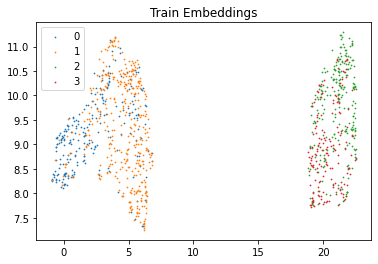

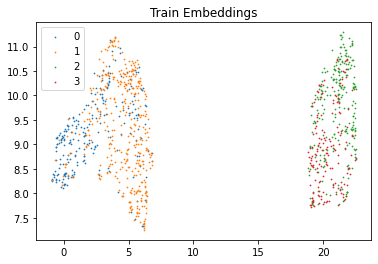

In [27]:
show_scatter(train_embeds[:, 0], train_embeds[:, 1],df_features_train['malignancy'],'Train Embeddings', 0.5)



We also do same visualization on cv and test

In [28]:
cv_test_embeds = reducer.transform(cv_test_features)

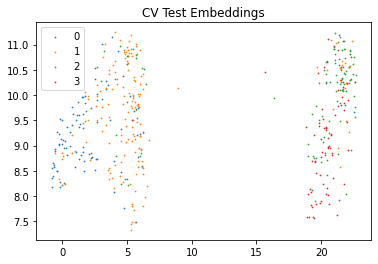

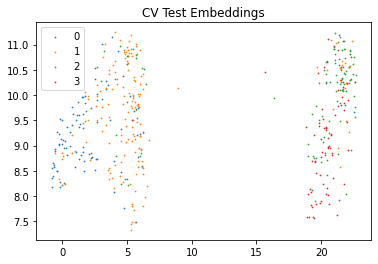

In [29]:
show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],df_features_cv_test['malignancy'],'CV Test Embeddings', 0.5)


Visualize on All

In [30]:
all_embeds = reducer.transform(all_features)

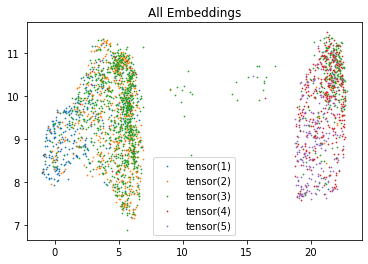

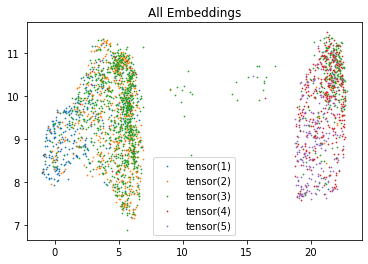

In [31]:
show_scatter(all_embeds[:, 0], all_embeds[:, 1],images_df['malignancy'],'All Embeddings', 0.5)


We now save the reduce

In [32]:
f_reducer = './cnn_umap_reducer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))




Note to lode from above file, we can call
```python
reducer = pickle.load((open(f_reducer, 'rb'))) 
```

### Feature Cluster

Now we cluster the training embeddings using Gaussian Mixture

We first visualize the silhouette score

(we only cluster on malignant since that is what we want)

In [33]:
train_embeds_malig = reducer.transform(train_features[df_features_train['malignancy'] > 1])

Text(0, 0.5, 'Silhouette Coefficients')

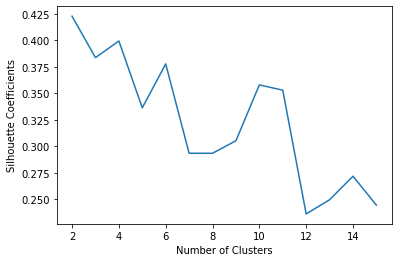

In [34]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  gmm = GaussianMixture(n_components=cluster, random_state=61).fit(train_embeds_malig)
  labels = gmm.predict(train_embeds_malig)
  
  silhouette_avg = silhouette_score(train_embeds_malig, labels)
  silhouette_coefficients.append(silhouette_avg)

plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

We note from above, the best number of subclasses is 2.

In [35]:
clusterer = GaussianMixture(n_components=2, random_state=61).fit(train_embeds_malig)

We now visualize the clusters ont train

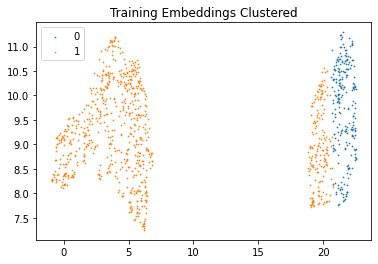

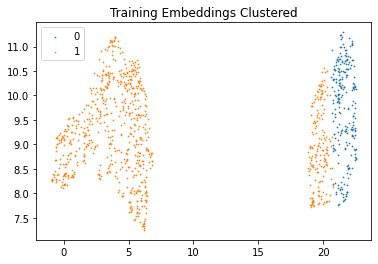

In [36]:
train_labels = clusterer.predict(train_embeds)

show_scatter(train_embeds[:, 0], train_embeds[:, 1],train_labels,'Training Embeddings Clustered', 0.5)

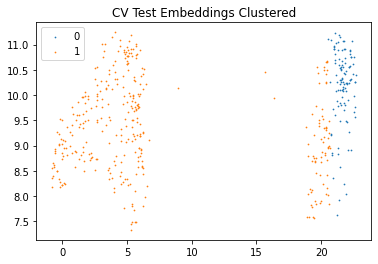

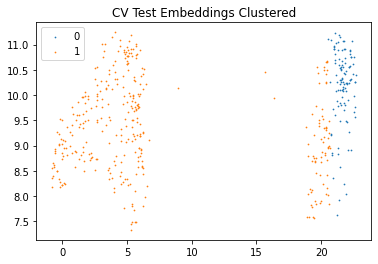

In [37]:
cv_test_labels = clusterer.predict(cv_test_embeds)

show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],cv_test_labels,'CV Test Embeddings Clustered', 0.5)

Now we save the clusterer

In [38]:
f_clusterer = './cnn_umap_clusterer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))

### Save the labels

Now that we have the labels, we want to save them to csv we so we can train gDRO on them

In [39]:
df_features_train['cluster'] = train_labels
df_features_cv_test['cluster'] = cv_test_labels

df_clusters = pd.concat([df_features_train, df_features_cv_test])[['noduleID', 'cluster']]
df_clusters.sort_values('noduleID', inplace=True)
df_clusters.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,noduleID,cluster
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0


We can add these lables to the df_splits dataframe

In [40]:
df_splits['cluster'] = [ 0 if m % 2 == 0 else 1 + c for m,c in zip(df_splits['malignancy_b'], df_clusters['cluster'])]

In [41]:
df_splits['cluster']

0       2
1       1
2       1
3       1
4       1
       ..
1483    2
1484    0
1485    0
1486    2
1487    0
Name: cluster, Length: 1488, dtype: int64

Now we save the csv

In [42]:
df_splits.to_csv('./data/LIDC_data_split_with_cluster(temp).csv')

## Train ERM and gDRO on new models

We again get our dataloaders (but with the new sublables)

In [43]:
df_splits = pd.read_csv('./data/LIDC_data_split_with_cluster(temp).csv', index_col=0)
df_splits.head()

,noduleID,split,malignancy,malignancy_b,spic_groups,cluster
0,1,0,3,1,3,2
1,2,0,3,1,2,1
2,3,1,3,1,3,1
3,4,0,2,1,3,1
4,5,2,2,1,2,1


In [51]:
train_data_c, cv_data_c, test_data_c = get_features(images=True, features=images_df, device=DEVICE, subclass='cluster')

#datasets
tr_c = SubclassedDataset(*train_data_c)
cv_c = SubclassedDataset(*cv_data_c)
tst_c = SubclassedDataset(*test_data_c)

#dataloaders
tr_loader_c = InfiniteDataLoader(tr_c, batch_size=128)
cv_loader_c = InfiniteDataLoader(cv_c, len(cv_c))
tst_loader_c = InfiniteDataLoader(tst_c, len(tst_c))

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/content/LIDC_GDRO/utils/image_data_utils.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['clusters'] = df_subclass[subclass]
/content/LIDC_GDRO/utils/image_data_utils.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [52]:
tr_loader_c_gdro = InfiniteDataLoader(tr_c, batch_size=128, weights=get_sampler_weights(tr_c.subclasses))


### ERM

In [62]:
model_ERM = TransferModel18(device=DEVICE, pretrained=True, freeze=False)

In [63]:
epochs = 15
loss_fn = ERMLoss(model_ERM, torch.nn.CrossEntropyLoss())
optimizer = torch.optim.AdamW(model_ERM.parameters(), lr=0.0005, weight_decay=0.005)
train_epochs(epochs, tr_loader_c, cv_loader_c, model_ERM, loss_fn, optimizer, scheduler=ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True), verbose=True, num_subclasses=4)

Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-07.


In [64]:
evaluate(tst_loader_c,model_ERM, 4)

(0.8803986710963455, 1.0, 0.8449612403100775, 0.8095238095238095, 1.0)

### GDRO

In [65]:
model_gDRO = TransferModel18(device=DEVICE, pretrained=True, freeze=False)

In [66]:
epochs = 15
loss_fn = GDROLoss(model_gDRO, torch.nn.CrossEntropyLoss(), 0.01, 4)
optimizer = torch.optim.AdamW(model_gDRO.parameters(), lr=0.0005, weight_decay=0.005)
train_epochs(epochs, tr_loader_c, tst_loader_c, model_gDRO, loss_fn, optimizer, scheduler=ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True), verbose=True, num_subclasses=4)

Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15 / 15


In [67]:
evaluate(tst_loader_c,model_gDRO, 4)

(0.8870431893687708, 1.0, 0.875968992248062, 0.7857142857142857, 1.0)